# Events Table Stratified

__Description__: 
A Stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data (or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max. potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for statified sampling; maximum return interval limit for the statified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the curves.


#### Import Libraries

In [24]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import mean_frequency_curve
%matplotlib inline

In [27]:
## Excess rainfall parameters:
CN  = 73       # Curve number
mu  = 0.2  #Intial abstraction ratio parameter
PMP = 20   #inches, Probable Maximum Precipitation for the selected duration 

Return_Intervals = np.array([ 2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000]) #Return Intervals evaluated
RI_upper_bound = 3700 #Upper Limit of recurrence interval evaluation, Suggest not changing this value
Aerial_Reduction = 1.0 #Aerial Reduction Factor

duration = 24   # Event duration in hour #Must be a duration in the input Precip_Table File

#Integration parameters
n_partition = 30 #Define number of partitions of max. potential retention distribution.
                 #This controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'DesPlaines'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN =         '071200040403'   # Domain/boundary condition name

#NOAA Data
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)
#Mean Precip Curve Data
precip_mean_curve_table = '{0}_{1}_{2}_MeanCurve.csv'.format(Project_Area, Pluvial_Model, BCN) 

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_plots = True
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [28]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [29]:
## Excess rainfall parameters:
lower_limit, upper_limit = 1, 3000 

## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### NOAA Atlas 14 Precipitation Values

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.379714,2.117918,2.702459
2,2.891592,2.574480,3.286755
5,3.701163,3.283337,4.207439
10,4.377602,3.863020,4.969184
25,5.377439,4.696378,6.100418
50,6.235949,5.403653,7.084265
100,7.189133,6.155010,8.170133
200,8.249031,6.967184,9.403857
500,9.851490,8.155633,11.288959


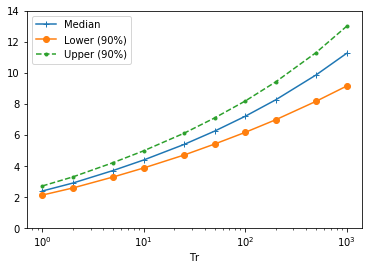

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)

raw_precip.rename(columns = {'Expected Value':'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, 14))

raw_precip

### Fit GEV to Rainfal Data (Find GEV parameters)

In [6]:
#reduce precip by aerial reduction factor
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns] * Aerial_Reduction

#Find GEV parameter values
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)

dfs = [df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U]
df_GEV_parameters = pd.concat(dfs, axis=1)
df_GEV_parameters

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04256935345698326
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.032377611868098656
            Iterations: 19
            Function evaluations: 106
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.056679706305320314
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13


,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.755150,2.446070,3.139833
sigma,0.574647,0.532820,0.627433
xi,-0.204410,-0.163136,-0.222317


### Plot Fitted GEV Distribution and NOAA Data

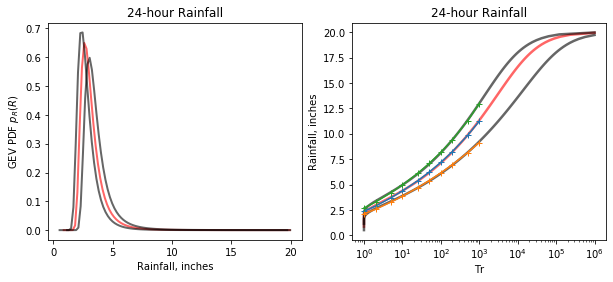

In [7]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP)

### Data for Calculating the Mean Curve

In [8]:
#Additional Return Intervals evaluated for the mean curve
return_intervals_MC =  np.array([ 1.01, 1.05, 1.11, 1.25, 20,\
                                 2000, 5000, 10000, 20000,\
                                 50000., 100000., 200000., 1/2E-06,\
                                1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07 ]) 

return_interval_data = return_interval_data(raw_precip_reduced, return_intervals_MC, df_GEV_parameters, PMP)
return_interval_data

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.379714,2.117918,2.702459,0.070849,0.077314,0.077314,0.866980
1.01,2.000418,1.724906,2.326368,0.090081,0.091764,0.091764,0.693356
1.05,2.182937,1.903610,2.520997,0.083234,0.087528,0.087528,0.780671
1.11,2.312590,2.028762,2.660104,0.079600,0.085105,0.085105,0.838368
1.25,2.494542,2.202098,2.856443,0.075802,0.082354,0.082354,0.914105
2.00,2.891592,2.574480,3.286755,0.070614,0.077868,0.077868,1.061807
5.00,3.701163,3.283337,4.207439,0.072819,0.077937,0.077937,1.308647
10.00,4.377602,3.863020,4.969184,0.076019,0.077054,0.077054,1.476501
20.00,5.101648,4.482087,5.776025,0.078708,0.075472,0.078708,1.629564
25.00,5.377439,4.696378,6.100418,0.082323,0.076684,0.082323,1.682212


### Input for Calculating the Mean Curve

In [9]:
#Confidence Limits Evaluated
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, .99, 0.995, 0.999])
#Inputs for the mean curve. Table is exported as a csv
mean_curve_input_table(CL, return_interval_data, PMP, outputs_dir, Project_Area, Pluvial_Model, BCN, inputs_dir)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,19.970397,19.975902,19.978447,19.984881,19.987934,19.991209,19.993246,19.994756,19.995968,19.996987,19.997870,19.998653,19.999358,19.999686,19.999938,19.999969,19.999994
2.000000e-07,19.925614,19.937968,19.943796,19.958977,19.966486,19.974844,19.980253,19.984390,19.987806,19.990756,19.993378,19.995758,19.997953,19.998993,19.999801,19.999901,19.999980
5.000000e-07,19.815981,19.846343,19.860686,19.898109,19.916662,19.937350,19.950766,19.961044,19.969543,19.976893,19.983435,19.989382,19.994871,19.997476,19.999501,19.999751,19.999950
1.000000e-06,19.638489,19.697529,19.725475,19.798586,19.834955,19.875633,19.902093,19.922416,19.939263,19.953861,19.966886,19.978749,19.989723,19.994939,19.998999,19.999500,19.999900
2.000000e-06,19.302906,19.414663,19.467749,19.607301,19.677146,19.755684,19.807056,19.846695,19.879692,19.908400,19.934113,19.957626,19.979466,19.989877,19.997997,19.999000,19.999800
5.000000e-06,18.421710,18.662069,18.777294,19.084023,19.240035,19.418002,19.536205,19.628593,19.706430,19.774946,19.837038,19.894500,19.948534,19.974544,19.994949,19.997477,19.999496
1.000000e-05,17.268592,17.656181,17.844101,18.352226,18.615977,18.922486,19.130225,19.295491,19.437109,19.563917,19.680886,19.791174,19.896987,19.948752,19.989784,19.994894,19.998979
2.000000e-05,15.668222,16.219407,16.490578,17.239018,17.638138,18.113977,18.445937,18.717095,18.955717,19.175479,19.384520,19.588543,19.792215,19.895304,19.978902,19.989440,19.997886
5.000000e-05,13.218629,13.923363,14.276857,15.279810,15.834640,16.520530,17.019997,17.445423,17.837154,18.217207,18.602163,19.009030,19.461082,19.715670,19.940177,19.969881,19.993942


### Calculate the Mean Precipitation Curve

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



,P_Mean_in,P_Median_in
AEP,,
0.9,2.267722,2.314617
0.5,2.947996,2.891592


C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs - already exists



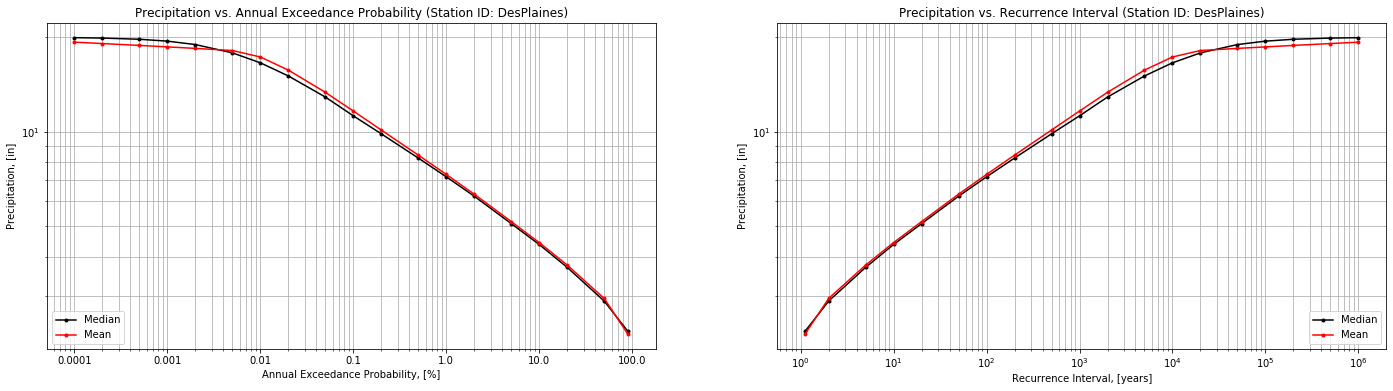

In [11]:
inputs_path= os.path.join(root_dir,'Inputs','Mean_Curve_Input_{0}_{1}_{2}.csv'.format(Project_Area, Pluvial_Model, BCN))
df = mean_frequency_curve.main(Project_Area, inputs_path, outputs_dir, data_type = 'P', round_decimals = 6)

## Hydrology 2

,Q_Mean_cfs,Q_Median_cfs
Tr,,
1.111111,2.372917,2.314617
2.000000,2.954968,2.891592
5.000000,3.765830,3.701163
10.000000,4.437855,4.377602
20.000000,5.184909,5.101648
50.000000,6.332596,6.235949
100.000000,7.317501,7.189133
200.000000,8.429844,8.249031
500.000000,10.132771,9.851490


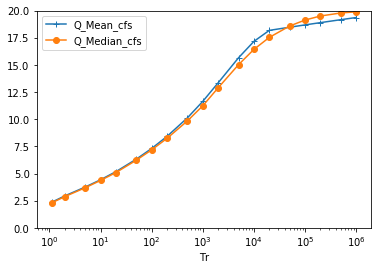

In [30]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)

mean_curve_precip['Tr'] = 1/mean_curve_precip.index.to_numpy()
mean_curve_precip = mean_curve_precip.set_index('Tr')

mean_curve_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, PMP))

mean_curve_precip

### Fit GEV to Mean Precipication Curve (Find GEV parameters)

In [13]:
#Find GEV parameters for the median curve
fit_values_mean_curve_precip = mean_curve_precip[1:20000] #Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.to_numpy().transpose()[0]

df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.032087531170973835
            Iterations: 14
            Function evaluations: 82
            Gradient evaluations: 14


,GEV Median,GEV Lower (90%),GEV Upper (90%),GEV P_Mean_in
mu,2.755150,2.446070,3.139833,2.693772
sigma,0.574647,0.532820,0.627433,0.595162
xi,-0.204410,-0.163136,-0.222317,-0.211864


### Plot Fitted GEV Distribution and Mean Precipitation Curve

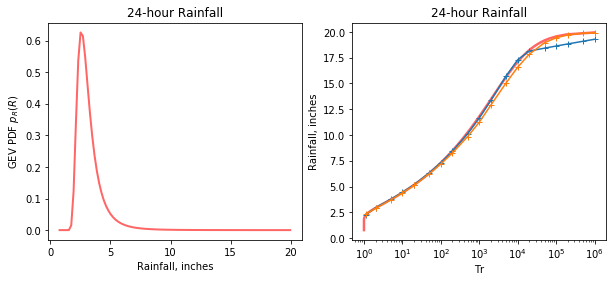

In [14]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP)

### Hydrology 2 Events

In [15]:
#Here add in script that processes the mean curve data points that are equivalent in RI to the original NOAA data points

#Return Intervals where precipitation already is calculated for the mean precip. curve.
RI_data = np.array([ 2, 5, 10, 50, 100, 200, 500, 1000, 2000])

df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', RI_data , CN, mu)
df_weights_rainfall

Bin Ceiling = 3700.0, Bin Average = 3000, Bin Floor = 2495.007131352185
Bin Ceiling = 2495.007131352185, Bin Average = 2000, Bin Floor = 1648.996384564383
Bin Ceiling = 1648.996384564383, Bin Average = 1000, Bin Floor = 684.1535086995412
Bin Ceiling = 684.1535086995412, Bin Average = 500, Bin Floor = 384.4447279257877
Bin Ceiling = 384.4447279257877, Bin Average = 200, Bin Floor = 125.37073631265552
Bin Ceiling = 125.37073631265552, Bin Average = 100, Bin Floor = 81.94097752391345
Bin Ceiling = 81.94097752391345, Bin Average = 50, Bin Floor = 34.17923252093143
Bin Ceiling = 34.17923252093143, Bin Average = 25, Bin Floor = 19.199275099556967
Bin Ceiling = 19.199275099556967, Bin Average = 10, Bin Floor = 6.28115925149448
Bin Ceiling = 6.28115925149448, Bin Average = 5, Bin Floor = 4.092000404992017
Bin Ceiling = 4.092000404992017, Bin Average = 2, Bin Floor = 1.2602231999279105


,Bin Floor,Bin Celing,Event Weight,P_Mean_in,Runoff
2.0,1.260223,4.092000,0.549131,2.947996,0.825553
5.0,4.092000,6.281159,0.085173,3.764722,1.360962
10.0,6.281159,19.199275,0.107121,4.439353,1.850063
25.0,19.199275,34.179233,0.022828,5.413927,2.609411
50.0,34.179233,81.940978,0.017054,6.329477,3.363914
100.0,81.940978,125.370736,0.004228,7.317239,4.210108
200.0,125.370736,384.444728,0.005375,8.428143,5.191140
500.0,384.444728,684.153509,0.001139,10.131265,6.737958
1000.0,684.153509,1648.996385,0.000855,11.644702,8.143092
2000.0,1648.996385,2495.007131,0.000206,13.357592,9.757643


# Hydrology 3
### Retreive Max. Potential Retention Variability and Distribution Parameters

In [16]:
#NRCS value of wet and dry soil moiture conditions
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

#Table of wet, dry, and average (or median) soil moisture conditions
df_CN = prep_cn_table(CN, arc_data)  

#Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)

#Distribution parameter values
S_limit = 1000/fitted_cn.iloc[0]['CN Lower Limit']-10
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

#Define Probability for each partition of the max. potential retention distribution.
Delta_P=1/n_partition

#Find the average value over each partition, which is the basis for the runoff distribution
partition_avg = partition_S_avgs(n_partition, alpha, beta, S_limit)
print(partition_avg )

fitted_cn['mu']= mu
fitted_cn

[ 0.46721141  0.96124733  1.32838278  1.64924009  1.94405423  2.2221562
  2.48886925  2.74763694  3.00089286  3.25048078  3.49788284  3.74435567
  3.99101879  4.23891713  4.48906994  4.74251339  5.00034219  5.26375528
  5.53411072  5.81299719  6.10233328  6.40451286  6.72263008  7.06084797
  7.42504473  7.82404899  8.27229238  8.79658066  9.45935888 10.55418328]


,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet),mu
1,54,73,87,1.691003,2.60077,44.909981,54.000151,73.000117,86.999903,0.2


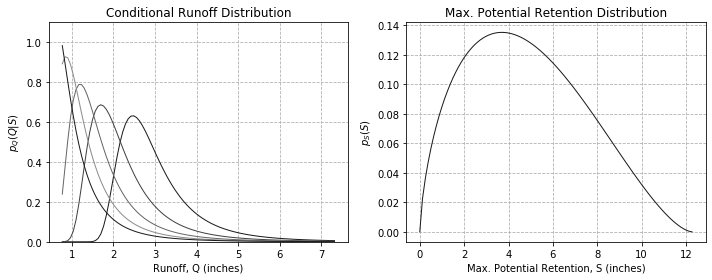

In [17]:
plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)

## Runoff as a function of the return period

In [18]:
#error between the integral approach (based on summation integration) and the actual value
error_PQ = 1- CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P)

#Print Results
print('\n'
      'Probability of zero runoff = %s \n' 
      'Error in calculation of Probabilibity of zero runoff = %s \n'
      'Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = %s'
      %(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[1], error_PQ ))

#Time the integration
#  %timeit CDF_Q( 3 , 0.2, alpha, beta, S_limit, GEV_parameters_E)


Probability of zero runoff = 0.0021870390014414017 
Error in calculation of Probabilibity of zero runoff = 2.003295929747215e-09 
Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = -0.0002818142008507163


### Determine Runoff Values and Weights
- Runoff weights calculated starting from a given bin ceiling.

In [19]:
#tck_RI_Q, tck_Q_RI respectively are cubic spline interpolation functions for runoff as a function of return period and return period as a function of runoff, respectively.
tck_RI_Q, tck_Q_RI, df_weights_runoff = runoff(Return_Intervals, RI_upper_bound, mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
df_weights_runoff

Bin Ceiling = 3700.0, Bin Floor 2492.26289201351
Bin Ceiling = 2492.26289201351, Bin Floor 1647.9482478238353
Bin Ceiling = 1647.9482478238353, Bin Floor 681.6887558474122
Bin Ceiling = 681.6887558474122, Bin Floor 384.8623655176635
Bin Ceiling = 384.8623655176635, Bin Floor 124.97516878707535
Bin Ceiling = 124.97516878707535, Bin Floor 82.15780216321271
Bin Ceiling = 82.15780216321271, Bin Floor 34.1267633968411
Bin Ceiling = 34.1267633968411, Bin Floor 19.48875374481685
Bin Ceiling = 19.48875374481685, Bin Floor 6.399630167026996
Bin Ceiling = 6.399630167026996, Bin Floor 3.8988108618530806
Bin Ceiling = 3.8988108618530806, Bin Floor 1.271115994314837


,Bin Floor,Bin Celing,Event Weight,Runoff
2,1.271116,3.898811,0.530222,0.691858
5,3.898811,6.399630,0.100229,1.548138
10,6.399630,19.488754,0.104947,2.160274
25,19.488754,34.126763,0.022009,2.990052
50,34.126763,82.157802,0.017131,3.709299
100,82.157802,124.975169,0.004170,4.547703
200,124.975169,384.862366,0.005403,5.535006
500,384.862366,681.688756,0.001131,7.110683
1000,681.688756,1647.948248,0.000860,8.532261
2000,1647.948248,2492.262892,0.000206,10.157187


### Plot runoff distribution

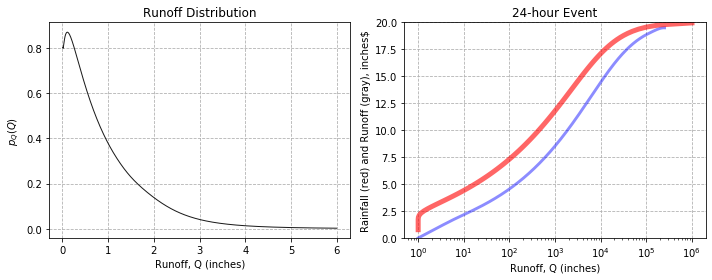

In [20]:
plot_runoff_distributions_final(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, tck_RI_Q)

### Plot maximum potential distribution conditional on runoff

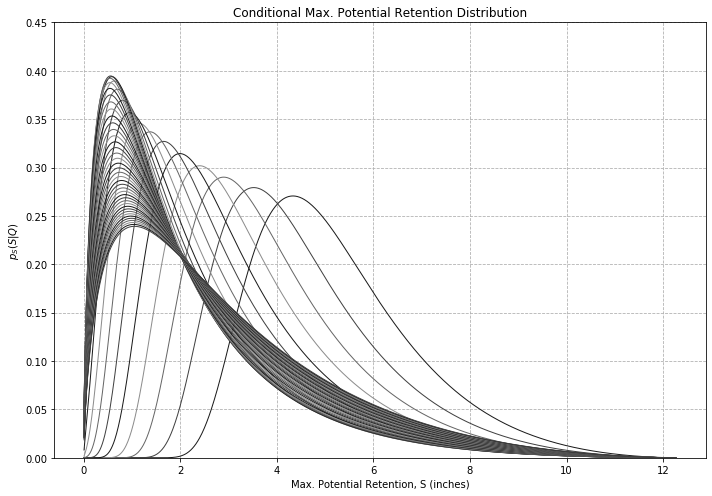

In [21]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P)

### Calculate Runoff and Corresponding Max. Potential Retention and Rainfall

In [22]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit)
df_runoff_SR1

Calculating Median S for Runoff = 0.6918577283031484
Calculating Median S for Runoff = 1.548138143769578
Calculating Median S for Runoff = 2.1602735828033235
Calculating Median S for Runoff = 2.990051510902505
Calculating Median S for Runoff = 3.709298686711971
Calculating Median S for Runoff = 4.547703479283829
Calculating Median S for Runoff = 5.53500608218582
Calculating Median S for Runoff = 7.110682559107755
Calculating Median S for Runoff = 8.532260724915607
Calculating Median S for Runoff = 10.157187199344486
Calculating Median S for Runoff = 11.192511927452951
Calculating Median S for Runoff = 14.217964078016983


,Bin Floor,Bin Celing,Event Weight,Runoff,Avg. S,Rainfall,Median S,Rainfall
2,1.271116,3.898811,0.530222,0.691858,4.559308,3.067227,4.228173,2.936545
5,3.898811,6.399630,0.100229,1.548138,2.775702,3.541980,2.327609,3.289626
10,6.399630,19.488754,0.104947,2.160274,2.183754,3.942625,1.731557,3.641698
25,19.488754,34.126763,0.022009,2.990052,2.077637,4.816984,1.513058,4.397488
50,34.126763,82.157802,0.017131,3.709299,2.165127,5.674535,1.575021,5.216282
100,82.157802,124.975169,0.004170,4.547703,2.300476,6.687716,1.710257,6.214256
200,124.975169,384.862366,0.005403,5.535006,2.455647,7.868523,1.872750,7.387611
500,384.862366,681.688756,0.001131,7.110683,2.669972,9.713015,2.105785,9.231403
1000,681.688756,1647.948248,0.000860,8.532261,2.830366,11.339837,2.281443,10.859661
2000,1647.948248,2492.262892,0.000206,10.157187,2.983889,13.165367,2.451235,12.688515


## Hydrology 3 Events
- For each runoff value, two events are considered, a high max. potential retention, and a low max. potential retention

In [23]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha,beta,S_limit)
df_runoff_SR2

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall,Event Weight,Runoff,Avg. S (Upper 50%),Rainfall
2,0.265111,0.691858,3.250988,2.535246,0.265111,0.691858,5.867629,3.563771
5,0.050115,1.548138,1.494930,2.779965,0.050115,1.548138,4.056475,4.208181
10,0.052474,2.160274,0.954569,3.067944,0.052474,2.160274,3.412938,4.684980
25,0.011005,2.990052,0.771397,3.780413,0.011005,2.990052,3.383876,5.686494
50,0.008565,3.709299,0.794679,4.540921,0.008565,3.709299,3.535575,6.630453
100,0.002085,4.547703,0.865026,5.464188,0.002085,4.547703,3.735926,7.728508
200,0.002702,5.535006,0.953121,6.554598,0.002702,5.535006,3.958173,8.996746
500,0.000566,7.110683,1.084222,8.283284,0.000566,7.110683,4.255721,10.956412
1000,0.000430,8.532261,1.184959,9.823860,0.000430,8.532261,4.475773,12.670501
2000,0.000103,10.157187,1.283960,11.567041,0.000103,10.157187,4.683817,14.580783


---